In [ ]:
# # IMDb Sentiment Analysis with LSTM
# This notebook implements an LSTM model for sentiment analysis on IMDb reviews

# # 1. Setup and Imports
# First, let's import all required libraries and modules.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# # 2. Data Loading and Preprocessing

In [4]:
# Load data
df = pd.read_csv('../../data/raw/IMDB Dataset.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
# Clean text function
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [6]:
# Apply cleaning
df['cleaned_review'] = df['review'].apply(clean_text)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [7]:
# Split data
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")


Train size: 35000
Validation size: 7500
Test size: 7500


In [ ]:
#  First, ensure your tokenizer is properly initialized
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['cleaned_review'])

#  When converting texts to sequences, cap indices at num_words-1
def texts_to_sequences_capped(tokenizer, texts):
    seq = tokenizer.texts_to_sequences(texts)
    return [[min(i, tokenizer.num_words - 1) for i in s] for s in seq]

#  Apply to all your data
train_sequences = texts_to_sequences_capped(tokenizer, train_df['cleaned_review'])
val_sequences = texts_to_sequences_capped(tokenizer, val_df['cleaned_review'])

In [ ]:
max_length = 200
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='post')

#  Verify no indices exceed vocab size
print(f"Max index in train: {np.max(train_padded)}")  # Should be 19999
print(f"Max index in val: {np.max(val_padded)}")    # Should be 19999

Max index in train: 19999
Max index in val: 19999


In [10]:
# Save tokenizer for later use
import pickle
with open('../../models/lstm/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [ ]:
# # 3. Model Building

In [17]:
# Define the LSTM architecture
# 1. Limit vocabulary size in Tokenizer (add this when creating tokenizer)
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')  # Top 20,000 words only

# 2. Update model building (remove input_length)
def build_lstm_model(vocab_size, embedding_dim=128, lstm_units=64):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),  # Removed input_length
        Bidirectional(LSTM(lstm_units, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(LSTM(lstm_units//2)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 3. Explicitly build the model by passing a sample input
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {min(vocab_size, 20000)}")  # Will use max 20,000 due to Tokenizer

model = build_lstm_model(min(vocab_size, 20000))  # Ensure we don't exceed num_words
model.build((None, 200))  # Explicitly build for 200-length sequences
model.summary()


Vocabulary size: 1


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 200, 128)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 200, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,385 (564.00 KB)

 Trainable params: 144,385 (564.00 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# # 4. Model Training

In [19]:
# Train the LSTM model with early stopping
# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('../../models/lstm/best_model.h5', save_best_only=True)
]

In [24]:
#  Rebuild your model with correct vocab_size
vocab_size = tokenizer.num_words  # Now guaranteed to be 20000
model = build_lstm_model(vocab_size)
model.build((None, max_length))  # Explicitly build with input shape

#  Now training should work
history = model.fit(
    train_padded,
    train_df['sentiment_label'].values,
    validation_data=(val_padded, val_df['sentiment_label'].values),
    epochs=10,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 131s 233ms/step - accuracy: 0.7279 - loss: 0.5114 - val_accuracy: 0.8711 - val_loss: 0.3052
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 164s 300ms/step - accuracy: 0.9006 - loss: 0.2642 - val_accuracy: 0.8747 - val_loss: 0.3186
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 110s 200ms/step - accuracy: 0.9455 - loss: 0.1589 - val_accuracy: 0.8472 - val_loss: 0.4535
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 107s 195ms/step - accuracy: 0.9649 - loss: 0.1087 - val_accuracy: 0.8560 - val_loss: 0.4189


In [25]:
# # 5. Evaluation and Visualization
# Analyze the model performance

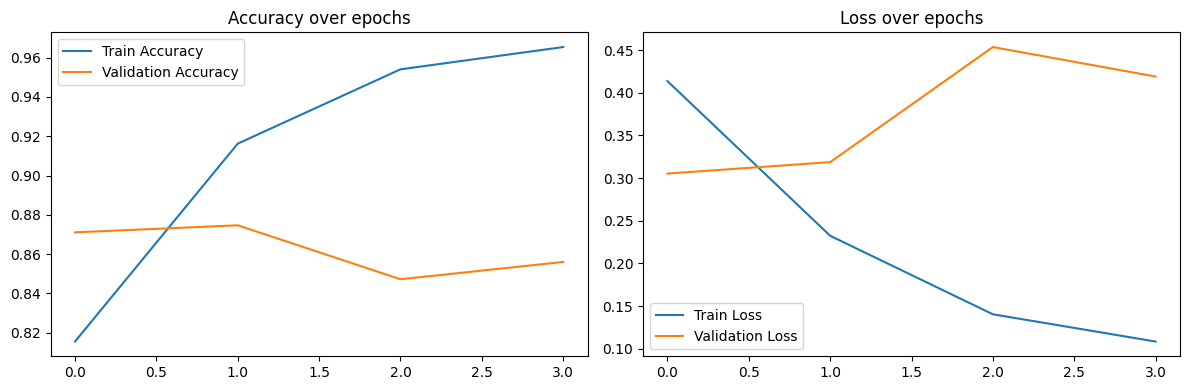

235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.8614 - loss: 0.3249
Test Accuracy: 0.8612


In [26]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.tight_layout()
plt.savefig('../../models/lstm/training_history.png')
plt.show()

# %%
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_padded, test_df['sentiment_label'].values)
print(f"Test Accuracy: {test_acc:.4f}")


In [27]:
# # 6. Prediction Function
# Create a function to make predictions on new text

In [28]:
def predict_sentiment(text):
    # Clean the text
    cleaned_text = clean_text(text)
    
    # Tokenize and pad
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    
    # Make prediction
    prediction = model.predict(padded)[0][0]
    sentiment = 'positive' if prediction >= 0.5 else 'negative'
    confidence = prediction if sentiment == 'positive' else 1 - prediction
    
    print(f"Text: {text[:200]}...")
    print(f"Predicted sentiment: {sentiment} (confidence: {confidence:.2%})")
    return sentiment, confidence


In [29]:
# Test prediction
sample_text = "This movie was absolutely fantastic! The acting was superb and the plot was engaging."
predict_sentiment(sample_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
Text: This movie was absolutely fantastic! The acting was superb and the plot was engaging....
Predicted sentiment: positive (confidence: 89.88%)


('positive', 0.89879113)

In [30]:
sample_text2 = "I hated this movie. The plot made no sense and the acting was terrible."
predict_sentiment(sample_text2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Text: I hated this movie. The plot made no sense and the acting was terrible....
Predicted sentiment: negative (confidence: 84.40%)


('negative', 0.8440081179141998)